## ASTR496: Foundations of Data Science in Astronomy
Gautham Narayan
gsn@illinois.edu

### Midterm

In [148]:
# Q1: Maximum Likelihood Estimation for Stellar Parameters
# Estimating Temperature and Extinction from Multi-band Photometry

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import cm
import emcee
import warnings
import corner
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

#### **Problem Setup:**
#### - We observe a star in multiple photometric bands (B, V, R, I, J, H, K)
#### - We want to estimate: stellar temperature T and visual extinction A_V
#### - We assume we know the distance from e.g. Gaia (or fit for it separately)
####
#### **Model:**
#### For each filter λ, the observed magnitude is:
####
#### m_λ = M_λ(T) + 5*log₁₀(d/10) + A_V * R_λ
####
#### where:
#### - M_λ(T) = absolute magnitude in filter λ for temperature T
#### - d = distance in parsecs
#### - A_V = visual extinction
#### - R_λ = extinction coefficient for filter λ

### First, I have to give you a stellar model as a function of wavelength
### We'll use a Planck function i.e. a blackbody

In [118]:
def planck_function(wavelength, temperature):
    """
    Planck function for blackbody radiation
    wavelength in microns, temperature in Kelvin
    Returns relative flux (arbitrary units)
    """
    h = 6.626e-34  # Planck constant
    c = 3e8        # Speed of light
    k = 1.381e-23  # Boltzmann constant

    wl_m = wavelength * 1e-6  # Convert to meters

    # Planck function
    numerator = 2 * h * c**2
    denominator = wl_m**5 * (np.exp(h * c / (wl_m * k * temperature)) - 1)

    return numerator / denominator

### Next we need to define a photometric system - we'll use the Johnson(-Morgan) Kron-Cousins UBVRI filters and the reddening coefficients 
### and JHK for the IR, largely because you can look up the filter's effective wavelengths $\lambda_\text{eff}$ in microns and the reddening coefficients from something like Cardelli-Clayton-Mathis '89.

In [119]:
filters = {
    'B': {'lambda_eff': 0.44, 'R_lambda': 4.1},   # Blue
    'V': {'lambda_eff': 0.55, 'R_lambda': 3.1},   # Visual (reference)
    'R': {'lambda_eff': 0.64, 'R_lambda': 2.7},   # Red
    'I': {'lambda_eff': 0.79, 'R_lambda': 2.0},   # Near-IR
    'J': {'lambda_eff': 1.25, 'R_lambda': 0.9},   # IR
    'H': {'lambda_eff': 1.63, 'R_lambda': 0.6},   # IR
    'K': {'lambda_eff': 2.19, 'R_lambda': 0.4}    # IR
}

In [120]:
# here are some quick arrays of the filters, wavelengths and reddening coefficients.
filter_names = list(filters.keys())
wavelengths = np.array([filters[f]['lambda_eff'] for f in filter_names])
R_lambda = np.array([filters[f]['R_lambda'] for f in filter_names])

print(f"Photometric filters: {filter_names}")
print(f"Effective wavelengths (μm): {wavelengths}")
print(f"Extinction coefficients R_λ: {R_lambda}")

Photometric filters: ['B', 'V', 'R', 'I', 'J', 'H', 'K']
Effective wavelengths (μm): [0.44 0.55 0.64 0.79 1.25 1.63 2.19]
Extinction coefficients R_λ: [4.1 3.1 2.7 2.  0.9 0.6 0.4]


### Next, we need to reate the magnitudes of a star, given the spectral model 
### While we are using the Planck function as an approximation, we'll tie the fluxes to the obsserved flux of the 
### Sun itself, with $T_\\text{eff}= 5778$K, and $M_V = 4.83$ (remember the absolute magnitude is defined for a distance of 10pc).

In [121]:
# Create stellar atmosphere model
def stellar_magnitude(temperature, filter_name, reference_temp=5778):
    """
    Calculate absolute magnitude for a star of given temperature
    Simplified model based on Planck function + calibration
    """
    wl = filters[filter_name]['lambda_eff']

    # Get flux ratio compared to solar temperature
    flux_star = planck_function(wl, temperature)
    flux_sun = planck_function(wl, reference_temp)
    flux_ratio = flux_star / flux_sun

    # Convert to magnitude difference (Sun has M_V = 4.83)
    # Add wavelength-dependent correction for more realism
    solar_magnitude = 4.83 + 0.5 * (wl - 0.55)  # Rough color correction

    magnitude = solar_magnitude - 2.5 * np.log10(flux_ratio)

    return magnitude

### Q1. As a function of temperature (3000-10,000K in 1000K steps) determine the B-V color

In [122]:
temperatures = np.arange(3000, 11000, 1000)
bv_colors = []

for temp in temperatures:
    B_mag = stellar_magnitude(temp, 'B')
    V_mag = stellar_magnitude(temp, 'V')
    bv_color = B_mag - V_mag
    bv_colors.append(bv_color)
    print(f"T = {temp} K : B-V = {bv_color:6.3f}")

T = 3000 K : B-V =  1.076
T = 4000 K : B-V =  0.485
T = 5000 K : B-V =  0.133
T = 6000 K : B-V = -0.099
T = 7000 K : B-V = -0.262
T = 8000 K : B-V = -0.381
T = 9000 K : B-V = -0.471
T = 10000 K : B-V = -0.542


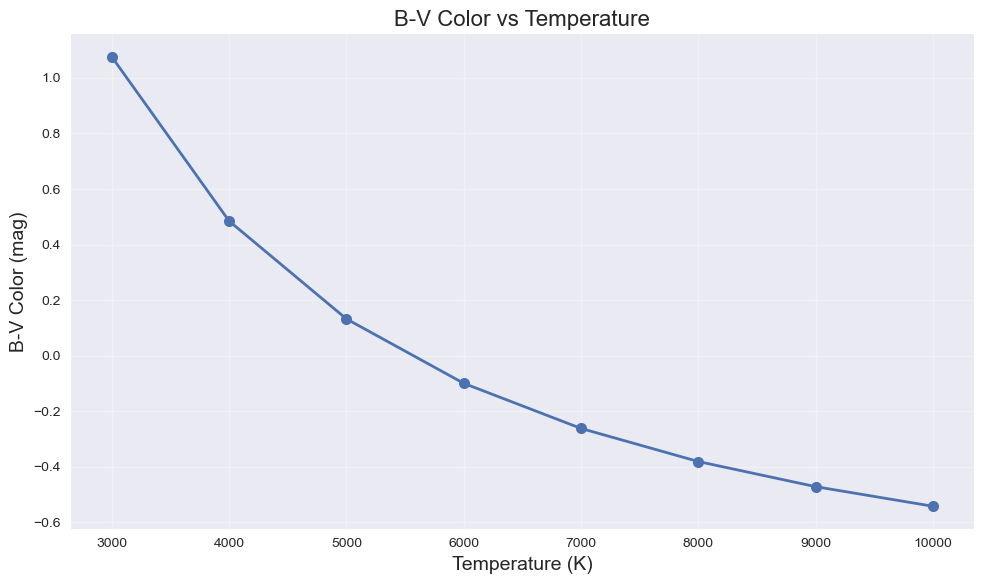

In [123]:
plt.figure(figsize=(10,6))
plt.plot(temperatures, bv_colors, 'o-', linewidth=2, markersize=8)
plt.xlabel('Temperature (K)', fontsize=14)
plt.ylabel('B-V Color (mag)', fontsize=14)
plt.title('B-V Color vs Temperature', fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Next, I'll give you the "Truth" and some synthetic stellar data, with the true magnitudes of this star in each band using my `stellar_magnitude` but with the reddening and distance correction applied (you're going to have to do this)

In [124]:
# Generate a test star
TRUE_TEMP = 6500  # K
TRUE_A_V = 0.8    # magnitudes
TRUE_DISTANCE = 100    # parsecs


synthetic_star =  {'B': {'magnitude': 12.379, 'error': 0.02, 'true_magnitude': 12.369},
                   'V': {'magnitude': 11.752, 'error': 0.03, 'true_magnitude': 11.756},
                   'R': {'magnitude': 11.579, 'error': 0.04, 'true_magnitude': 11.553},
                   'I': {'magnitude': 11.225, 'error': 0.05, 'true_magnitude': 11.149},
                   'J': {'magnitude': 10.602, 'error': 0.06, 'true_magnitude': 10.616},
                   'H': {'magnitude': 10.592, 'error': 0.07, 'true_magnitude': 10.609},
                   'K': {'magnitude': 10.888, 'error': 0.08, 'true_magnitude': 10.762}}

### Q2.  
### OK, you know the drill 
### define a function that gives you the model magnitudes of the star given the temperature, extinction and distance
### define the log-likelihood
### Use `scipy.optimize` to get the best fit parameters for this star using maximum likelihood estimation
### Calculate the goodness of fit i.e. reduced chi-squared
### Calculate the Inverse Hessian Matrix and report the simple uncertainties on each parameter
### Which parameters are correlated strongly?

In [125]:
def model_magnitude(temperature, A_V, distance, filter_name):
    absolute_mag = stellar_magnitude(temperature, filter_name)
    distance_mod = 5 * np.log10(distance / 10)
    R_lamda_ratio = filters[filter_name]['R_lambda'] / filters['V']['R_lambda']
    A_lamda = A_V * R_lamda_ratio
    return absolute_mag + distance_mod + A_lamda

def neg_log_likelihood(params, data, filter_names):
    temperature, A_V, distance = params
    
    if temperature < 2000 or temperature > 50000:
        return 1e10
    if A_V < 0 or A_V > 5:
        return 1e10
    if distance < 1 or distance > 10000:
        return 1e10
    
    chi2 = 0

    for filter_name in filter_names:
        obs_mag = data[filter_name]['magnitude']
        error = data[filter_name]['error']
        model_mag = model_magnitude(temperature, A_V, distance, filter_name)
        chi2 += ((obs_mag - model_mag) / error) ** 2
    return chi2


In [126]:
# Initial guess
initial_guess = [5500, 0.5, 75]  # Temperature, A_V, Distance


### YOUR ANSWER HERE
filter_names = list(synthetic_star.keys())

result = minimize(neg_log_likelihood, initial_guess,
                  args = (synthetic_star, filter_names),
                  method='Nelder-Mead',
                  options = {'maxiter' : 10000})

In [127]:
best_params = result.x
best_temp, best_av, best_dist = best_params

print("Best Fit Parameters:")
print(f"Temperature: {best_temp:.1f} K  (True: {TRUE_TEMP} K)")
print(f"A_V: {best_av:.3f} mag (True: {TRUE_A_V} mag)")
print(f"Distance: {best_dist:.1f} pc  (True: {TRUE_DISTANCE} pc)")

Best Fit Parameters:
Temperature: 7639.9 K  (True: 6500 K)
A_V: 2.921 mag (True: 0.8 mag)
Distance: 111.8 pc  (True: 100 pc)


In [128]:
chi2_min = result.fun
n_data = len(filter_names)
n_params = 3
dof = n_data - n_params
reduced_chi2 = chi2_min / dof

print("Goodness of Fit:")
print(f"chi2 = {chi2_min:.2f}")
print(f"Reduced chi2 = {reduced_chi2:.2f}")

Goodness of Fit:
chi2 = 3.31
Reduced chi2 = 0.83


In [129]:
epsilon = np.array([10, 0.01, 0.5])
hessian = np.zeros((3,3))

for i in range(3):
    for j in range(3):
        params_pp = best_params.copy()
        params_pm = best_params.copy()
        params_mp = best_params.copy()
        params_mm = best_params.copy()

        params_pp[i] += epsilon[i]
        params_pp[j] += epsilon[j]
        params_pm[i] += epsilon[i]
        params_pm[j] -= epsilon[j]
        params_mp[i] -= epsilon[i]
        params_mp[j] += epsilon[j]
        params_mm[i] -= epsilon[i]
        params_mm[j] -= epsilon[j]

        f_pp = neg_log_likelihood(params_pp, synthetic_star, filter_names)
        f_pm = neg_log_likelihood(params_pm, synthetic_star, filter_names)
        f_mp = neg_log_likelihood(params_mp, synthetic_star, filter_names)
        f_mm = neg_log_likelihood(params_mm, synthetic_star, filter_names)

        hessian[i,j] = (f_pp - f_pm - f_mp + f_mm) / (4 * epsilon[i] * epsilon[j])

In [130]:
try:
    covariance_mat = np.linalg.inv(hessian)
    uncertainties = np.sqrt(np.diag(covariance_mat))
    correlation_mat = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            correlation_mat[i,j] = covariance_mat[i,j] / (uncertainties[i] * uncertainties[j])

    print(f"Parameter Uncertainties:")
    print(f"sigma(T) = {uncertainties[0]:.1f} K")
    print(f"sigma(A_V) = {uncertainties[1]:.3f} mag")
    print(f"sigma(dist) = {uncertainties[2]:.1f} pc")

    print(f"\nCorrelation Matrix:")
    print("         T        A_V     dist")
    param_names = ['T  ', 'A_V', 'dist']
    for i, name in enumerate(param_names):
        print(f"{name}", end="")
        for j in range(3):
            print(f"   {correlation_mat[i,j]:6.3f}", end="")
        print()
    print(f"\nStrongly Correlated Pairs (|rho| > 0.5):")
    for i in range(3):
        for j in range(i+1, 3):
            if abs(correlation_mat[i,j]) > 0.5:
                print(f"    {param_names[i].strip()} - {param_names[j].strip()}: rho = {correlation_mat[i,j]:.3f}")

except np.linalg.LinAlgError:
    print("Warning")

Parameter Uncertainties:
sigma(T) = 1123.7 K
sigma(A_V) = 0.385 mag
sigma(dist) = 9.5 pc

Correlation Matrix:
         T        A_V     dist
T      1.000    0.998    0.988
A_V    0.998    1.000    0.975
dist    0.988    0.975    1.000

Strongly Correlated Pairs (|rho| > 0.5):
    T - A_V: rho = 0.998
    T - dist: rho = 0.988
    A_V - dist: rho = 0.975


### Q3.

### It is worth remembering the difference between Monte Carlo and Markov Chain Monte Carlo
### Using the same true parameters provided to you with Q2, generate 1000 random stars with the same true values, but different random seeds
### Repeat your analysis in Q2 for each of these 1000 stars, saving the results
### Use the results from this Monte Carlo process to determine a more robust uncertainty estimate, and measure the mean bias (i.e. how far are you from the truth) in parameter recovery

In [131]:
### YOUR ANSWER HERE

n_realizations = 1000
mc_results = {'temperature' : [], 'av': [], 'dist' : []}

np.random.seed(42)

for i in range(n_realizations):
    noisy_star = {}
    for filter_name in filter_names:
        true_mag = synthetic_star[filter_name]['true_magnitude']
        error = synthetic_star[filter_name]['error']
        noisy_mag = true_mag + np.random.normal(0, error)
        noisy_star[filter_name] = {
            'magnitude' : noisy_mag,
            'error' : error,
            'true_magnitude' : true_mag
        }
    result_mc = minimize(neg_log_likelihood, initial_guess,
                         args = (noisy_star, filter_names),
                         method='Nelder-Mead',
                         options={'maxiter' : 5000})
    
    if result_mc.success:
        mc_results['temperature'].append(result_mc.x[0])
        mc_results['av'].append(result_mc.x[1])
        mc_results['dist'].append(result_mc.x[2])

    if (i + 1) % 200 == 0:
        print(f" Completed {i + 1}/{n_realizations} realizations")

 Completed 200/1000 realizations
 Completed 400/1000 realizations
 Completed 600/1000 realizations
 Completed 800/1000 realizations
 Completed 1000/1000 realizations


In [132]:
mc_temp = np.array(mc_results['temperature'])
mc_av = np.array(mc_results['av'])
mc_dist = np.array(mc_results['dist'])

print(f"Monte Carlo Result ({len(mc_temp)} successful fits):")
print(f"\nTemperature:")
print(f"  Mean: {np.mean(mc_temp):.1f} +/- {np.std(mc_temp):.1f} K")
print(f"  Bias: {np.mean(mc_temp) - TRUE_TEMP:.1f} K")
print(f"\nA_V:")
print(f"  Mean: {np.mean(mc_av):.3f} +/- {np.std(mc_av):.1f} mag")
print(f"  Bias: {np.mean(mc_av) - TRUE_A_V:.3f} mag")
print(f"\nDistance:")
print(f"  Mean: {np.mean(mc_dist):.1f} +/- {np.std(mc_dist):.1f} pc")
print(f"  Bias: {np.mean(mc_dist) - TRUE_DISTANCE:.1f} pc")

Monte Carlo Result (1000 successful fits):

Temperature:
  Mean: 6784.8 +/- 1496.0 K
  Bias: 284.8 K

A_V:
  Mean: 2.466 +/- 0.6 mag
  Bias: 1.666 mag

Distance:
  Mean: 101.7 +/- 12.8 pc
  Bias: 1.7 pc


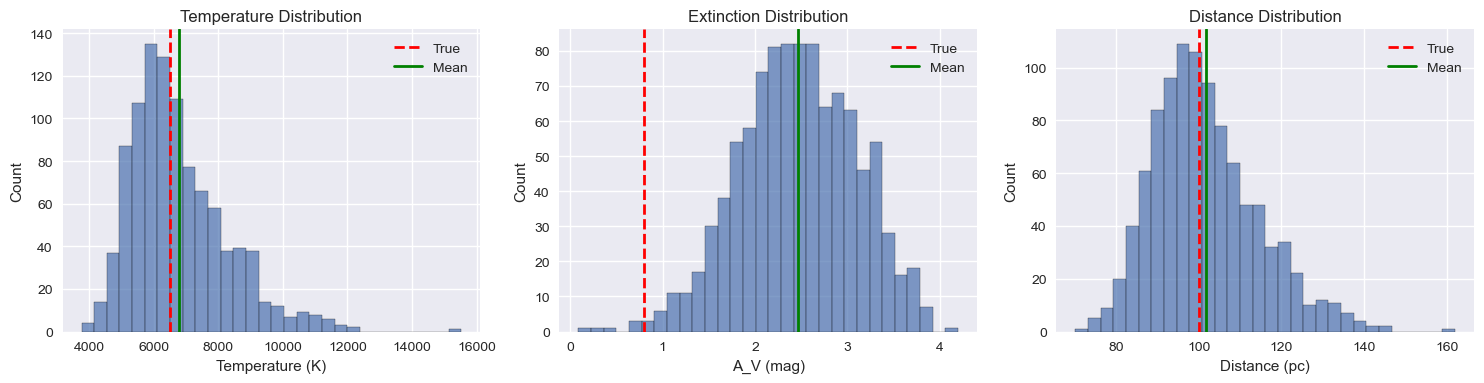

In [133]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))
axes[0].hist(mc_temp, bins=30, alpha=0.7, edgecolor='black')
axes[0].axvline(TRUE_TEMP, color='r', linestyle='--', linewidth=2, label='True')
axes[0].axvline(np.mean(mc_temp), color='g', linestyle='-', linewidth=2, label='Mean')
axes[0].set_xlabel('Temperature (K)')
axes[0].set_ylabel('Count')
axes[0].set_title('Temperature Distribution')
axes[0].legend()

axes[1].hist(mc_av, bins=30, alpha=0.7, edgecolor='black')
axes[1].axvline(TRUE_A_V, color='r', linestyle='--', linewidth=2, label='True')
axes[1].axvline(np.mean(mc_av), color='g', linestyle='-', linewidth=2, label='Mean')
axes[1].set_xlabel('A_V (mag)')
axes[1].set_ylabel('Count')
axes[1].set_title('Extinction Distribution')
axes[1].legend()

axes[2].hist(mc_dist, bins=30, alpha=0.7, edgecolor='black')
axes[2].axvline(TRUE_DISTANCE, color='r', linestyle='--', linewidth=2, label='True')
axes[2].axvline(np.mean(mc_dist), color='g', linestyle='-', linewidth=2, label='Mean')
axes[2].set_xlabel('Distance (pc)')
axes[2].set_ylabel('Count')
axes[2].set_title('Distance Distribution')
axes[2].legend()

plt.tight_layout()
plt.show()

### Q4. 

### Finally, try this problem with a Markov Chain Monte Carlo but this time, incorporating a prior on the distance of 98 +/- 5 pc from synthetic Gaia, but repeating the anaysis three times - once with all filters, next with RIJHK and then with BVRIJ only.

#### Make reasonable choices for the number of walkers, steps, thinning etc. It's your responsibility to ensure the posteriors are well sampled.

### Show corner plots for all three cases in the same figure (you can try the `ChainConsumer` package)

### How do these results compare, and what happens to the extinction and temperature with fewer bands, and in the case of all filters, with your answer from Q2/Q3. 

In [146]:
### YOUR ANSWER HERE
def log_prior(params, use_distance_prior=True):
    temperature, A_V, distance = params
    
    if not (2000 < temperature < 50000):
        return -np.inf
    if not (0 < A_V < 5):
        return -np.inf
    if not (1 < distance < 10000):
        return -np.inf
    
    if use_distance_prior:
        gaia_distance = 98
        gaia_error = 5
        log_p_dist = -0.5 * ((distance - gaia_distance) / gaia_error) ** 2
        return log_p_dist
    return 0.0

def log_probability(params, data, filter_names, use_distance_prior=True):
    lp = log_prior(params, use_distance_prior)
    if not np.isfinite(lp):
        return -np.inf
    
    chi2 = neg_log_likelihood(params, data, filter_names)
    return lp - 0.5 * chi2

def run_mcmc(filter_list, label, use_distance_prior=True):
    """Run MCMC for a given set of filters"""
    print(f"\n--- {label} ---")
    print(f"Filters: {', '.join(filter_list)}")
    
    n_walkers = 32
    ndim = 3
    nsteps = 10000 
    
    start_temp = 6500  
    start_av = 0.8      
    start_dist = 98   
    
    pos = []
    max_attempts = 1000
    attempts = 0
    
    while len(pos) < n_walkers and attempts < max_attempts:
        p = np.array([
            start_temp + np.random.randn() * 200,    
            start_av + np.random.randn() * 0.15,     
            start_dist + np.random.randn() * 8      
        ])
        
        if (4000 < p[0] < 9000 and 
            0.1 < p[1] < 2.0 and 
            70 < p[2] < 130):
            
            lp = log_probability(p, synthetic_star, filter_list, use_distance_prior)
            if np.isfinite(lp):
                pos.append(p)
        
        attempts += 1
    
    if len(pos) < n_walkers:
        print(f"Warning: Only found {len(pos)} valid positions")
        while len(pos) < n_walkers:
            base = pos[np.random.randint(len(pos))]
            new_pos = base + np.random.randn(3) * np.array([50, 0.05, 2])
            pos.append(new_pos)
    
    pos = np.array(pos)
    
    print(f"Initialized {len(pos)} walkers")
    print(f"Temperature range: [{pos[:, 0].min():.0f}, {pos[:, 0].max():.0f}] K")
    print(f"A_V range: [{pos[:, 1].min():.3f}, {pos[:, 1].max():.3f}] mag")
    print(f"Distance range: [{pos[:, 2].min():.1f}, {pos[:, 2].max():.1f}] pc")
    
    sampler = emcee.EnsembleSampler(
        n_walkers, ndim, log_probability,
        args=(synthetic_star, filter_list, use_distance_prior)
    )
    
    print(f"\nRunning {n_walkers} walkers for {nsteps} steps...")
    
    sampler.run_mcmc(pos, nsteps, progress=False, skip_initial_state_check=True)
    
    try:
        tau = sampler.get_autocorr_time(quiet=True)
        print(f"\nAutocorrelation time: {tau}")
        
        burnin = max(2000, int(3 * np.max(tau)))
        thin = max(1, int(0.5 * np.min(tau)))
        
        if nsteps < 50 * np.max(tau):
            print(f"WARNING: Chain may not be converged. Need ~{int(50*np.max(tau))} steps")
    except:
        print("Could not compute autocorrelation time")
        burnin = 2000
        thin = 10
    
    print(f"Mean acceptance fraction: {np.mean(sampler.acceptance_fraction):.3f}")
    
    samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
    
    print(f"Discarded {burnin} steps as burn-in")
    print(f"Thinning by factor of {thin}")
    print(f"Final chain has {len(samples)} samples")
    
    temp_samples = samples[:, 0]
    av_samples = samples[:, 1]
    dist_samples = samples[:, 2]
    
    print(f"\nResults:")
    print(f"  T    = {np.median(temp_samples):.1f} +/- {np.std(temp_samples):.1f} K")
    print(f"         (16-84 percentile: [{np.percentile(temp_samples, 16):.1f}, {np.percentile(temp_samples, 84):.1f}])")
    print(f"  A_V  = {np.median(av_samples):.3f} +/- {np.std(av_samples):.3f} mag")
    print(f"         (16-84 percentile: [{np.percentile(av_samples, 16):.3f}, {np.percentile(av_samples, 84):.3f}])")
    print(f"  dist = {np.median(dist_samples):.1f} +/- {np.std(dist_samples):.1f} pc")
    print(f"         (16-84 percentile: [{np.percentile(dist_samples, 16):.1f}, {np.percentile(dist_samples, 84):.1f}])")
    
    print(f"\nComparison to truth:")
    print(f"  T:    True={TRUE_TEMP} K,   Recovered={np.median(temp_samples):.1f} K")
    print(f"  A_V:  True={TRUE_A_V} mag, Recovered={np.median(av_samples):.3f} mag")
    print(f"  dist: True={TRUE_DISTANCE} pc,  Recovered={np.median(dist_samples):.1f} pc")
    
    return samples

In [147]:
samples_all = run_mcmc(filter_names, "All filters (BVRIJHK)")
samples_red = run_mcmc(['R', 'I', 'J', 'H', 'K'], "Red Filters (RIJHK)")
samples_opt = run_mcmc(['B', 'V', 'R', 'I', 'J'], "Optical + J (BVRIJ)")


--- All filters (BVRIJHK) ---
Filters: B, V, R, I, J, H, K
Initialized 32 walkers
Temperature range: [6159, 6807] K
A_V range: [0.529, 1.102] mag
Distance range: [78.1, 110.9] pc

Running 32 walkers for 10000 steps...

Autocorrelation time: [199.37770321 197.88205456 181.97378737]
Mean acceptance fraction: 0.509
Discarded 2000 steps as burn-in
Thinning by factor of 90
Final chain has 2816 samples

Results:
  T    = 6374.1 +/- 575.0 K
         (16-84 percentile: [5870.0, 6925.8])
  A_V  = 2.395 +/- 0.334 mag
         (16-84 percentile: [2.101, 2.670])
  dist = 100.5 +/- 5.3 pc
         (16-84 percentile: [95.8, 105.1])

Comparison to truth:
  T:    True=6500 K,   Recovered=6374.1 K
  A_V:  True=0.8 mag, Recovered=2.395 mag
  dist: True=100 pc,  Recovered=100.5 pc

--- Red Filters (RIJHK) ---
Filters: R, I, J, H, K
Initialized 32 walkers
Temperature range: [6159, 6857] K
A_V range: [0.511, 1.052] mag
Distance range: [77.8, 120.1] pc

Running 32 walkers for 10000 steps...

Autocorrelatio

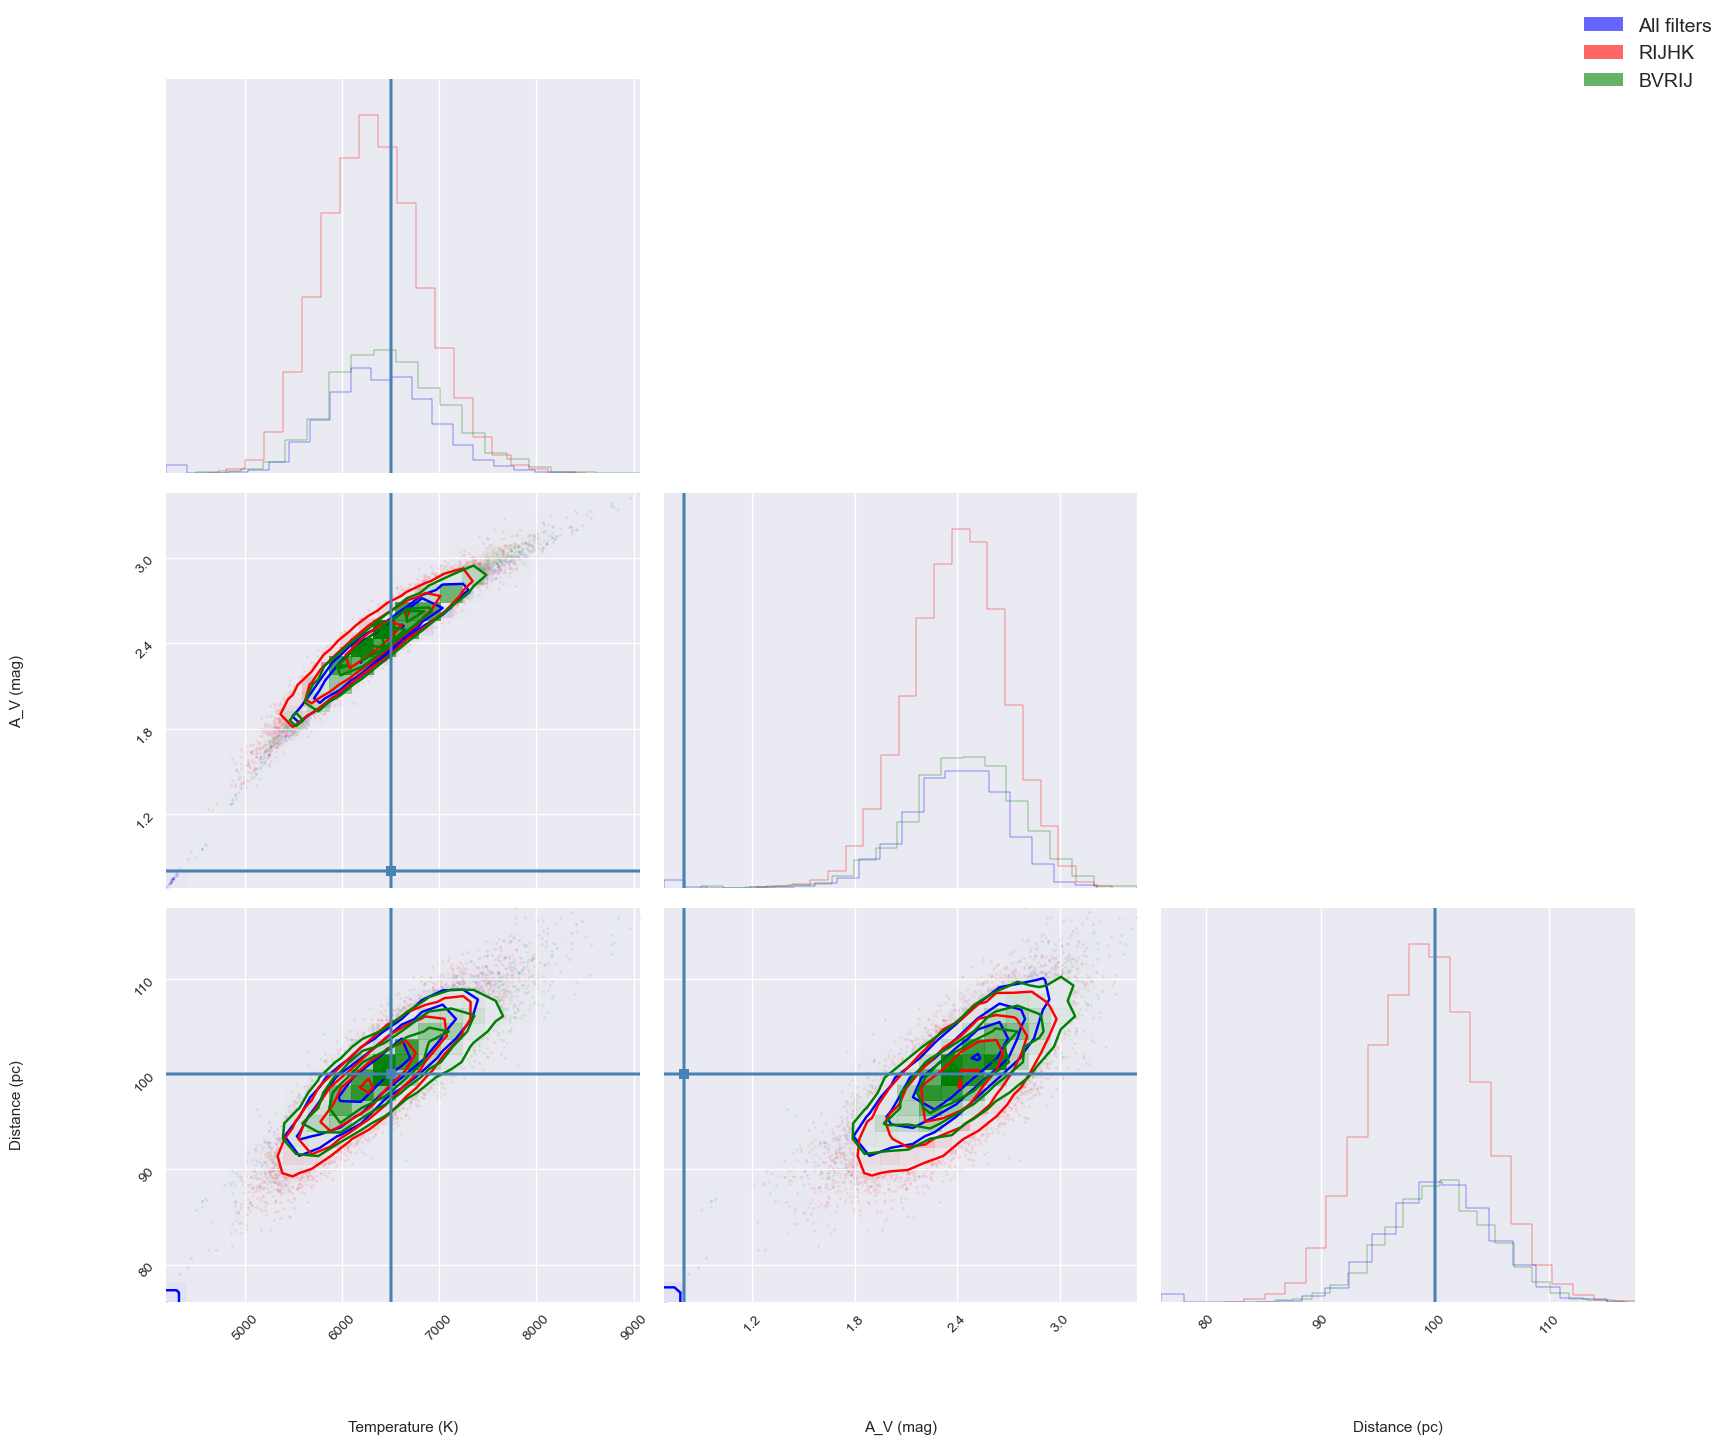

In [152]:
fig = plt.figure(figsize=(18,15))

labels = ['Temperature (K)', 'A_V (mag)', 'Distance (pc)']
truths = [TRUE_TEMP, TRUE_A_V, TRUE_DISTANCE]

corner.corner(samples_all, labels=labels, truths=truths,
              color='blue', fig=fig, alpha=0.6)
corner.corner(samples_red, labels=labels, truths=truths,
              color='red', fig=fig, alpha=0.6)
corner.corner(samples_opt, labels=labels, truths=truths,
              color='green', fig=fig, alpha=0.6)

from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor='blue', alpha=0.6, label='All filters'),
    Patch(facecolor='red', alpha=0.6, label='RIJHK'),
    Patch(facecolor='green', alpha=0.6, label='BVRIJ')
]

fig.legend(handles=legend_elements, loc='upper right', fontsize=14)

plt.show()